In [1]:
#here we demonstrate TCSPC fitting with instrument response function convolution
#the code depends on jupyter, numpy, pandas, matplotlib, and scipy
#with pixi (https://pixi.prefix.dev/latest/installation/) just run pixi run jupyter lab in this folder

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as so
from scipy.interpolate import RegularGridInterpolator

In [3]:
df=pd.read_csv('sim_lifetime.csv',index_col=0)
df.head()

,time,intensity,irf
0,0.00,2.0,0
1,0.05,2.0,0
2,0.10,5.0,0
3,0.15,5.0,0
4,0.20,3.0,1


In [4]:
#define the time per channel in ns
chsize=df.iloc[1]['time']-df.iloc[0]['time']
nchan=len(df)
#wraparound determines whether long time delay photons reappear at the start of the time window
wraparound=False
#define the interpolation class for the irf
interp=RegularGridInterpolator([np.arange(nchan)],df['irf'].values,method='linear',
                               fill_value=0.0,bounds_error=False)
#get the parameter guesses (irfshift,baseline,amp1,tau1,amp2,...,tau4)
gparams=[0.0,0.0, #irfshift and baseline
         1,4.0, #component 1
         0.0,0.0, #component 2
         0.0,0.0, #component 3
         0.0,0.0]  #component 4
#the parameter names for display later
paramnames=['irfshift','baseline','amp1','tau1','amp2','tau2','amp3','tau3','amp4','tau4']
#define which parameters we want fixed in our fit
fixes=[False,False,False,False,False,False,True,True,True,True]

In [5]:
def convolveIrf(xvals,irfinterp,shift,amp,tau):
    '''
    convolve a single exponential with an irf
    each irf channel should create it's one exponential from that point
    if wraparound (global param) is true need to take values beyond the array and wrap to the beginning
    the irf is provided by a RegularGridInterpolator object for shifting
    '''
    nchan=len(xvals)
    chsize=xvals[1]-xvals[0]
    convolved=np.zeros([nchan*2],dtype=np.float32)
    irfshift=irfinterp(np.arange(nchan)-shift)
    for i in range(len(irfshift)):
        if(irfshift[i]>0.0):
            xvals2=np.arange(nchan*2-i)*chsize
            convolved[i:]+=amp*irfshift[i]*np.exp(-xvals2/tau)
    convolved2=convolved[:nchan]
    if(wraparound):
        convolved2+=convolved[nchan:]
    return convolved2

In [6]:
def mapUnfixedParams(params,fixes,gparams):
    '''
    map the unfixed parameters to the whole set
    '''
    params2=gparams.copy()
    pos=0
    for i in range(len(params2)):
        if(not fixes[i]):
            params2[i]=params[pos]
            pos+=1
    return params2

def unmapParams(params,fixes):
    '''
    return the unfixed parameters from the whole parameter set
    '''
    return np.array(params)[~np.array(fixes)]

def lifetimefunc(xvals,*params):
    '''
    returns a lifetime function
    params are irfshift, baseline, amp1, tau1, amp2, ..., amp4
    the global "fixes" array determines how many exponentials are fit
    the global gparams array determines the fixed parameter values
    '''
    #start by getting a set of parameters that includes the fixed values
    params2=mapUnfixedParams(params,fixes,gparams)
    #print(params2)
    fitfuncs=[np.full(len(xvals),fill_value=params2[1])]
    for i in range(4):
        if(params2[i*2+2]!=0.0):
            fitfuncs.append(convolveIrf(xvals,interp,params2[0],params2[i*2+2],params2[i*2+3]))
    return np.array(fitfuncs).sum(axis=0)

def lifetimefunc2(xvals,*params):
    '''
    returns a lifetime function
    params are irfshift, baseline, amp1, tau1
    this version fixes nothing
    '''
    fitfuncs=[np.full(len(xvals),fill_value=params[1])]
    fitfuncs.append(convolveIrf(xvals,interp,params[0],params[2],params[3]))
    return np.array(fitfuncs).sum(axis=0)

In [7]:
def getBounds(guessparams,fixes,data):
    '''
    get the bounds based on the guess params values
    '''
    gparams2=mapUnfixedParams(guessparams,fixes,gparams)
    bounds=[[0.0]*len(gparams2),[0.0]*len(gparams2)]
    totamp=data.max()-data.min()
    #start by guessing the irfshift parameters
    bounds[0][0]=-0.1*totamp
    bounds[1][0]=0.1*totamp
    bounds[0][1]=-0.1*totamp
    bounds[1][1]=0.1*totamp
    for i in range(2,len(gparams2),2):
        bounds[0][i]=0.25*gparams2[i]
        bounds[1][i]=4.0*gparams2[i]
        bounds[0][i+1]=0.25*gparams2[i+1]
        bounds[1][i+1]=4.0*gparams2[i+1]
    return [unmapParams(bounds[0],fixes),unmapParams(bounds[1],fixes)]

In [8]:
#guess the parameters we are not fixing
gparams2=[0.0,0.0,0.1,4.0,0.3,1.0]
#set the lower and upper bounds for those parameters
bounds=getBounds(gparams2,fixes,df['intensity'].values)
#for photon counting data, the variance proportional to the intensity
weights=np.sqrt(df['intensity'].values)
weights[df['intensity'].values<1.0]=1.0 #avoid 0 weight for 0 intensities

In [9]:
bounds

[array([-2.156e+02, -2.156e+02,  2.500e-02,  1.000e+00,  7.500e-02,
         2.500e-01]),
 array([215.6, 215.6,   0.4,  16. ,   1.2,   4. ])]

In [10]:
fitparams,covmat=so.curve_fit(lifetimefunc,df['time'].values,df['intensity'].values,
                              p0=gparams2,sigma=weights,bounds=bounds,method='trf')
errs = np.sqrt(np.diag(covmat))
fit=lifetimefunc(df['time'].values,*fitparams)
chi_squared=(((df['intensity'].values-fit)/weights)**2).sum()/(len(df)-np.sum(~np.array(fixes)))
print('raw fit params',fitparams)
print('errors',errs)
print('chi squared',chi_squared)

raw fit params [0.0662355  4.19718106 0.06540663 3.92523945 0.23286147 1.00812889]
errors [0.0056856  0.22450482 0.00051451 0.01022093 0.0011994  0.00304368]
chi squared 1.2058228193720886


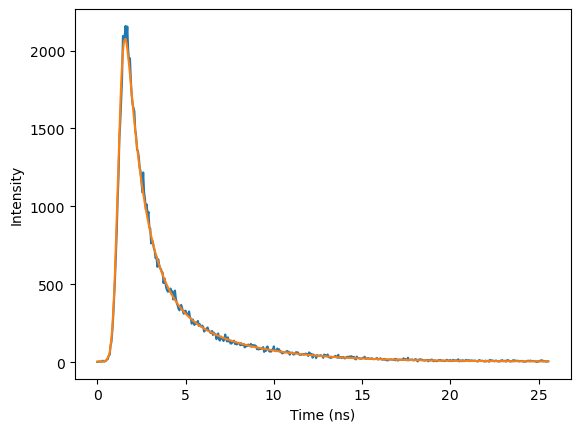

In [11]:
plt.plot(df['time'].values,df['intensity'].values)
plt.plot(df['time'].values,fit)
plt.xlabel('Time (ns)')
plt.ylabel('Intensity')
#if you want to save the fit figure
#plt.savefig('lifetime_fit.pdf')
plt.show()

In [12]:
df['fit']=fit
#if you want to save the fit
#df.to_csv('lifetime_fit.csv')

In [13]:
paramdf=pd.DataFrame({'parameter':paramnames,
              'value':mapUnfixedParams(fitparams,fixes,gparams),
              'error':mapUnfixedParams(errs,fixes,[0.0]*len(gparams))}).set_index('parameter')
paramdf

,value,error
parameter,,
irfshift,0.066236,0.005686
baseline,4.197181,0.224505
amp1,0.065407,0.000515
tau1,3.925239,0.010221
amp2,0.232861,0.001199
tau2,1.008129,0.003044
amp3,0.000000,0.000000
tau3,0.000000,0.000000
amp4,0.000000,0.000000


In [14]:
#if you want to save the parameters
#paramdf.to_csv('lifetime_fit_parameters.csv'